In [1]:
import os
import cv2
import easyocr
import numpy as np
import pandas as pd
from PIL import Image
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


C:\Users\User\anaconda3\envs\easyocr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Medecine dataset

In [2]:
# Load the XLS file
df = pd.read_excel('../data/med.xls')

# Keep only the 'Nom' column
df = df[['Nom']]

# Remove duplicate values
df = df.drop_duplicates()

# Save the cleaned data to a new Excel file
df.to_excel('cleaned_file.xlsx', index=False)

# Print a preview
print(df.head())
# Load the cleaned names once
df = pd.read_excel('cleaned_file.xlsx')
name_list = df['Nom'].dropna().astype(str).tolist()


                     Nom
0         5-FLUOROURACIL
1  5-FLUOROURACILE EBEWE
3             ABBOTICINE
4                 ABEVMY
6              ABILICARE


## image preprocessing

In [3]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1,  5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    return clahe.apply(image)

def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [4]:
image_file = "../data/raw_data/Prescriptions/0750--9550274--20230705_page_2.jpg"
img = cv2.imread(image_file)
if img is None:
    print("Error: Image not found!")
else:
    # Apply preprocessing
    gray = grayscale(img)
    sharpened = sharpen(gray)
    denoised = noise_removal(sharpened)
    enhanced = enhance_contrast(denoised)
    processed_img = thick_font(enhanced)
#Save the image
line_path = os.path.join("../data/processed_trocr/Prescriptions", "0750--9550274--20230705_page_2.jpg")
cv2.imwrite(line_path, processed_img)


True

In [5]:
# image_file = "output/prescription1.jpg"
# img = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)  # Keep original format
# # If the image has multiple channels, take only the first channel
# if len(img.shape) == 3:  # If image has 3 dimensions (H, W, C)
#     img = img[:, :, 0]   # Extract the first channel

# # Binarization using Otsu's Thresholding (Text should be white, background black)
# _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# #Save the image
# line_path = os.path.join("output", "binary.jpg")
# cv2.imwrite(line_path, binary)

# # Display the grayscale image
# # cv2.imshow("Grayscale Image", binary)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.imshow(binary)


In [6]:
# # Load the binary image (ensure it's in grayscale)
# image_file = "output/binary.jpg"
# binary = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)  # Ensure it's in grayscale

# # Apply thresholding to force values to 0 (background) or 255 (text)
# _, binary = cv2.threshold(binary, 127, 255, cv2.THRESH_BINARY)

# # Check unique values again after cleaning
# unique_values_cleaned = np.unique(binary)
# print(f"Unique values after cleaning: {unique_values_cleaned}")

# # Display the cleaned binary image
# plt.imshow(binary, cmap='gray')
# plt.axis("off")  # Hide axes
# plt.show()

# # Check if the cleaned image contains only 0 and 255
# if set(unique_values_cleaned) == {0, 255}:
#     print("The cleaned binary image meets the condition: text is 255, background is 0.")
# else:
#     print("The cleaned binary image still does not meet the condition.")


## Projection methode

In [7]:
# # Assuming `binary` is the preprocessed binary image (text as 255, background as 0)
# # Compute horizontal projection profile (sum of pixel values per row)
# projection = np.sum(binary, axis=1)

# # Smooth the projection profile to reduce small dips within a line
# projection = gaussian_filter1d(projection, sigma=3)

# # Debugging: Print the min, max, and mean of the projection to understand the range
# print("Projection stats - Min:", np.min(projection), "Max:", np.max(projection), "Mean:", np.mean(projection))

# # Set a dynamic threshold based on the projection stats
# max_projection = np.max(projection)
# threshold = max(max_projection * 0.1, 50)  # At least 50, or 10% of max
# print("Using threshold:", threshold)

# # Find line boundaries based on the projection threshold
# lines = []
# start = None
# for i in range(len(projection)):
#     if projection[i] > threshold and start is None:
#         start = i
#     elif projection[i] <= threshold and start is not None:
#         # Only append if the line is wide enough (e.g., at least 30 pixels tall)
#         if i - start >= 30:
#             lines.append((start, i))
#         start = None

# # Handle the case where the last line extends to the end of the image
# if start is not None and len(projection) - start >= 30:
#     lines.append((start, len(projection)))

# # Merge close lines (if the gap between lines is less than 20 pixels)
# merged_lines = []
# if lines:
#     current_start, current_end = lines[0]
#     for start, end in lines[1:]:
#         if start - current_end <= 5:  # Merge if gap is small
#             current_end = end
#         else:
#             merged_lines.append((current_start, current_end))
#             current_start, current_end = start, end
#     merged_lines.append((current_start, current_end))

# # Add padding to each line to ensure full text is captured
# padded_lines = []
# padding = 60  # Add 60 pixels of padding to top and bottom
# for start, end in merged_lines:
#     new_start = max(0, start - padding)
#     new_end = min(len(projection), end + padding)
#     padded_lines.append((new_start, new_end))
# # Display the line boundaries found
# print("Line boundaries:", lines)


In [8]:
# # Create the output directory if it doesn't exist
# output_dir = "output"
# try:
#     os.makedirs(output_dir, exist_ok=True)
#     print(f"Created output directory: {output_dir}")
# except Exception as e:
#     print(f"Error creating output directory: {e}")


In [9]:
# # Crop each line and store in memory (instead of saving to disk)
# line_images = []
# for i, (start, end) in enumerate(padded_lines):
#     # Crop the line from the binary image
#     line_image = binary[start:end, :]
#     if line_image.size > 0:  # Ensure the image is not empty
#         line_images.append(line_image)
#         print(f"Prepared line {i+1} in memory")

# # Function to segment a line image into words based on gaps
# def segment_words(line_img):
#     # Ensure the image is binary (text as 255, background as 0)
#     _, binary = cv2.threshold(line_img, 127, 255, cv2.THRESH_BINARY)


#     # Get the dimensions of the line image
#     height, width = binary.shape
#     print("Image width is ",width)
#     # Scan column by column to find gaps
#     gap_threshold = 100  # Minimum gap size in pixels to consider as a word boundary
#     gaps = []
#     gap_start = None
#     gap_count = 0

#     for col in range(width):
#         # Check if the entire column is background (all pixels are 0)
#         if np.all(binary[:, col] < 100):
#             if gap_start is None:
#                 gap_start = col
#             gap_count += 1
#         else:
#             # If we were in a gap and hit text, check if the gap was large enough
#             if gap_start is not None and gap_count >= gap_threshold:
#                 gap_end = col
#                 gaps.append((gap_start, gap_end))
#             gap_start = None
#             gap_count = 0

#     # Handle the case where the last gap extends to the end of the image
#     if gap_start is not None and gap_count >= gap_threshold:
#         gaps.append((gap_start, width))

#     # Define word boundaries based on gaps
#     word_boundaries = []
#     if not gaps:
#         # If no gaps are found, treat the entire line as one word
#         word_boundaries.append((0, width))
#     else:
#         # Start with the first word (from the beginning to the first gap)
#         if gaps[0][0] > 0:  # If there's text before the first gap
#             word_boundaries.append((0, gaps[0][0]))

#         # Add words between gaps
#         for i in range(len(gaps) - 1):
#             start = gaps[i][1]
#             end = gaps[i + 1][0]
#             if end - start >= 50:  # Minimum width for a word
#                 word_boundaries.append((start, end))

#         # Add the last word (from the last gap to the end)
#         if gaps[-1][1] < width:  # If there's text after the last gap
#             word_boundaries.append((gaps[-1][1], width))

#     # Crop each word
#     word_images = []
#     for i, (start, end) in enumerate(word_boundaries):
#         padding = 2  # Add small padding to each word
#         new_start = max(0, start - padding)
#         new_end = min(width, end + padding)
#         word_img = binary[:, new_start:new_end]
        
#         if word_img.shape[:2][1] > 50:  # Ensure the image is not too small by comparing the width of the image 
#             word_images.append(word_img)
#             # Visualize the word image
#             plt.figure(figsize=(5, 5))  # Optional: adjust figure size
#             plt.imshow(word_img, cmap='gray')
#             plt.title(f'Word {i+1}')  # Title to show the word number
#             plt.axis('off')  # Turn off axis
#             plt.show()  # Show the word image


#     return word_images, word_boundaries

# # Segment each line into words
# all_word_images = []
# all_word_boundaries = []
# for line_idx, line_img in enumerate(line_images):
#     print(f"\nSegmenting words in Line {line_idx + 1}:")
#     word_images, word_boundaries = segment_words(line_img)
#     all_word_images.append(word_images)
#     all_word_boundaries.append(word_boundaries)

#     for word_idx, word_img in enumerate(word_images):
#         output_path = os.path.join(output_dir, f"line{line_idx + 1}_word{word_idx + 1}.png")
#         try:
#             cv2.imwrite(output_path, word_img)
#             print(f"Saved word {word_idx + 1} of line {line_idx + 1} to {output_path}")
#         except Exception as e:
#             print(f"Error saving word {word_idx + 1} of line {line_idx + 1}: {e}")

#     # Print word boundaries for this line
#     print(f"Word boundaries for Line {line_idx + 1}: {word_boundaries}")
#     print(f"Number of words detected: {len(word_images)}") 


In [10]:

# # Save each line as an image in the output directory
# for i, (start, end) in enumerate(padded_lines):
#     # Crop the line from the binary image
#     line_image = binary[start:end, :]
#     # Save the cropped image
#     output_path = os.path.join(output_dir, f"line_{i+1}.png")
#     try:
#         cv2.imwrite(output_path, line_image)
#         print(f"Saved line {i+1} to {output_path}")
#     except Exception as e:
#         print(f"Error saving line {i+1}: {e}")

# # Display the line boundaries found
# print("Merged and padded line boundaries:", padded_lines)


In [11]:
# Initialize EasyOCR reader for French and Arabic
reader = easyocr.Reader(['fr'], gpu=False)  # Set gpu=True if you have a GPU

# # Load the prescription image
# image_path = "../data/processed_trocr/Prescriptions/ayoub.jpg"  # Replace with your image path
# image = cv2.imread(image_path)

# Create the output directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


Using CPU. Note: This module is much faster with a GPU.


In [12]:
# # Estimate average box height to set width_ths
# prelim_results = reader.readtext(image, detail=1, paragraph=False)
# box_heights = []
# for (bbox, _, _) in prelim_results:
#     (top_left, _, bottom_right, _) = bbox
#     height = bottom_right[1] - top_left[1]
#     box_heights.append(height)

# avg_box_height = np.mean(box_heights) if box_heights else 193  # Use known average height if no boxes
# print(f"Average box height: {avg_box_height:.2f} pixels")

# # Set merging parameters
# merge_gap_pixels = 10  # Allow up to 10 pixels gap
# width_ths = merge_gap_pixels / avg_box_height  # Convert to units of box height
ycenter_ths = 0.3  # Allow 30% of box height for vertical alignment (increased for safety)
height_ths = 2  # Allow boxes with similar heights to merge
# slope_ths = 0.1  # Keep default for horizontal text
# add_margin = 0.2  # Extend boxes slightly to avoid cutting off text

#print(f"Setting width_ths to {width_ths:.3f} (for {merge_gap_pixels}-pixel gap)")


In [13]:
# Detect words using EasyOCR with custom merging parameters
results = reader.readtext(
    processed_img,
    detail=1,
    paragraph=False,
    # slope_ths=slope_ths,
    ycenter_ths=ycenter_ths,
    height_ths=height_ths,
    # width_ths=width_ths,
    # add_margin=add_margin
)

In [14]:
# Process each detected (and merged) word
for idx, (bbox, text, prob) in enumerate(results):
    # Extract the bounding box coordinates
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    # Crop the word from the image
    word_img = processed_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Save the word image
    if word_img.shape[0] > 70 and word_img.shape[1] > 70:  # height and width
        output_path = os.path.join(output_dir, f"word_{idx+1}.png")
        cv2.imwrite(output_path, word_img)
        print(f"Saved word {idx+1} to {output_path} (Text: {text}, Confidence: {prob:.2f})")

# # Print the detected text for reference
# print("\nDetected Text (after merging):")
# for idx, (bbox, text, prob) in enumerate(results):
#     print(f"Word {idx+1}: {text} (Confidence: {prob:.2f})")

Saved word 2 to output\word_2.png (Text: dglaa '4 ljsi J91  = Jl, Confidence: 0.02)
Saved word 5 to output\word_5.png (Text: Ay, Confidence: 0.30)
Saved word 6 to output\word_6.png (Text: 06 2023, Confidence: 0.64)
Saved word 20 to output\word_20.png (Text: Bwn, Confidence: 0.43)
Saved word 21 to output\word_21.png (Text: Qu, Confidence: 0.31)
Saved word 22 to output\word_22.png (Text: Wa l4., Confidence: 0.23)
Saved word 23 to output\word_23.png (Text: Adul ke,, Confidence: 0.42)
Saved word 24 to output\word_24.png (Text: Vk, Confidence: 0.49)
Saved word 25 to output\word_25.png (Text: Y, Confidence: 0.98)
Saved word 26 to output\word_26.png (Text: 2, Confidence: 1.00)
Saved word 27 to output\word_27.png (Text: (Jes, Confidence: 0.13)
Saved word 28 to output\word_28.png (Text: pecdavk 3, Confidence: 0.05)
Saved word 29 to output\word_29.png (Text: Yw, Confidence: 0.90)
Saved word 30 to output\word_30.png (Text: Lfnlow n €, Confidence: 0.14)
Saved word 32 to output\word_32.png (Text: T

In [15]:
def match_word_to_names(word, threshold=60):
    matches = []
    for name in name_list:
        similarity = fuzz.ratio(word.lower(), name.lower())
        if similarity >= threshold:
            matches.append((name, similarity))
    return matches


In [16]:
# Load TrOCR model and processor for French handwritten text
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")


C:\Users\User\anaconda3\envs\easyocr\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Load line images from the "output" directory
output_dir = "output"
line_images = []
for filename in os.listdir(output_dir):
    if filename.startswith("word") and filename.endswith(".png"):
        img_path = os.path.join(output_dir, filename)
        line_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if line_img is not None:
            # Convert grayscale to RGB by duplicating the channel
            line_img_rgb = cv2.cvtColor(line_img, cv2.COLOR_GRAY2RGB)  # Shape: (height, width) -> (height, width, 3)
            line_images.append(line_img_rgb)

C:\Users\User\anaconda3\envs\easyocr\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


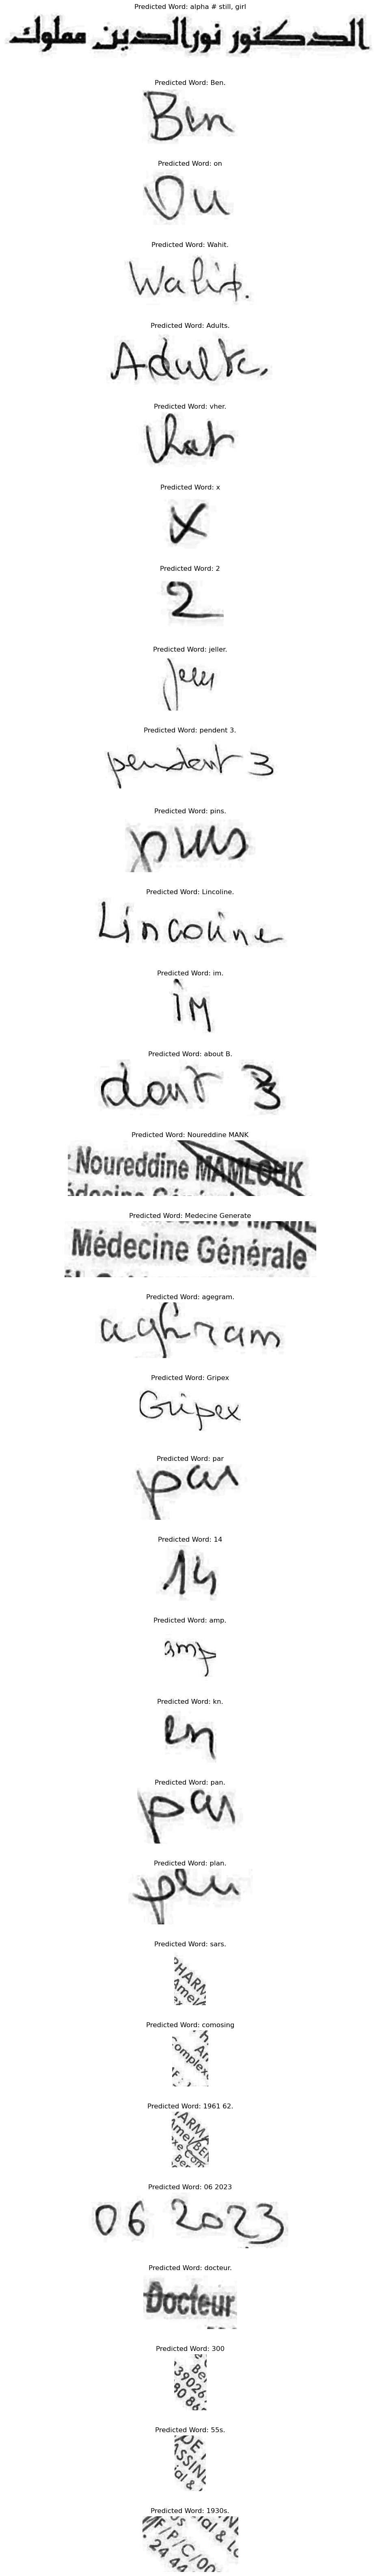

In [18]:
plt.figure(figsize=(10, len(line_images) * 2))  # Adjust figure size based on number of lines
predicted_images_text=[]
for i, line_img in enumerate(line_images):
    # Convert to PIL Image for TrOCR
    pil_img = Image.fromarray(line_img, mode='RGB')
    
    # Preprocess and generate text
    pixel_values = processor(pil_img, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    if text.strip():
        predicted_images_text.append(text)
    else:
        predicted_images_text.append("No text detected")  # Placeholder for empty text

    # Create subplot and show image
    plt.subplot(len(line_images), 1, i + 1)
    plt.imshow(line_img)
    plt.title(f"Predicted Word: {text}", fontsize=12)
    plt.axis('off')

# Adjust layout with extra padding to prevent overlap
plt.tight_layout(pad=3.0)
plt.show()

In [19]:
for pred in predicted_images_text:
    predict = match_word_to_names(pred, threshold=60)
    # Prepare the message
    print(f"Matches for \033[1m{pred}\033[0m")
    if predict:
        # Loop through all the matches
        for matched_name, similarity in predict:
            print(f"\033[1m'{matched_name}'\033[0m (Similarity: {similarity}%)")
    else:
        print(f"No match for {pred}")
    print("\n")
    # Show matches

Matches for alpha # still, girl
No match for alpha # still, girl


Matches for Ben.
'BENMAK' (Similarity: 60%)
'BRUFEN' (Similarity: 60%)
'BUDENA' (Similarity: 60%)
'EBEFEN' (Similarity: 60%)


Matches for on
No match for on


Matches for Wahit.
No match for Wahit.


Matches for Adults.
'CADUET' (Similarity: 62%)
'GLYSS ADULTES' (Similarity: 60%)
'VERAX ADULTES' (Similarity: 60%)


Matches for vher.
'H.E.C' (Similarity: 60%)
'TAVER' (Similarity: 60%)
'VERAX' (Similarity: 60%)


Matches for x
No match for x


Matches for 2
No match for 2


Matches for jeller.
No match for jeller.


Matches for pendent 3.
No match for pendent 3.


Matches for pins.
'P.N.D' (Similarity: 60%)
'PERINASE' (Similarity: 62%)


Matches for Lincoline.
'COCCULINE' (Similarity: 63%)
'COLIMYCINE' (Similarity: 60%)
'CYTOXALINE' (Similarity: 60%)
'FINGOLINE' (Similarity: 74%)
'GLIBENCLAMIDE' (Similarity: 61%)
'INDOCINE' (Similarity: 67%)
'INFLOCINE' (Similarity: 63%)
'LIDOCAINE' (Similarity: 63%)
'LINCOCINE' (Similar

# Create annotation files for fine tunning

In [20]:
# import os

# def create_annotation_file(data_dir, output_file):
#     with open(output_file, "w") as f:
#         for label in os.listdir(data_dir):  # Loop through label folders (A, B, C, ...)
#             label_dir = os.path.join(data_dir, label)
#             if os.path.isdir(label_dir):  # Ensure it's a directory
#                 for image_name in os.listdir(label_dir):  # Loop through images in label folder
#                     image_path = os.path.join(label_dir, image_name)
#                     f.write(f"{image_path}\t{label}\n")  # PaddleOCR format: "image_path \t label"

# # Generate annotation files for training & validation
# create_annotation_file("../data/finetune/Train", "../data/finetune/train_labels.txt")
# create_annotation_file("../data/finetune/Validation", "../data/finetune/val_labels.txt")

# print("Annotation files created successfully!")
